In [174]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

imputer = SimpleImputer(strategy='mean')


In [166]:
df = pd.read_excel("Hackathon_Data.xlsx")

test_hidden = df.loc[df['Load_data'].isnull()]
march_2024_data = df[(df['DateAndHour'] >= '2024-03-01') & (df['DateAndHour'] < '2024-04-01')]

df_cleaned = df.dropna()

# Step 2: Remove non-numeric values from 'Load_data'
# We'll use `pd.to_numeric` with `errors='coerce'` to convert non-numeric values to NaN
df_cleaned['Load_data'] = pd.to_numeric(df_cleaned['Load_data'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['Load_data'])
df_cleaned['Load_data'] = df_cleaned['Load_data'].astype(int)
df_cleaned.reset_index(drop=True, inplace=True)
df = df_cleaned

# df.set_index('DateAndHour', inplace=True)


test_hidden.head()


/var/folders/p9/h1b4st6s2mb7lqlw2lykztjw0000gn/T/ipykernel_34133/2415292475.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Load_data'] = pd.to_numeric(df_cleaned['Load_data'], errors='coerce')


DateAndHour Load_data  Temperature
8857 2024-03-26 01:00:00       NaN     2.322725
8858 2024-03-26 02:00:00       NaN     2.422725
8859 2024-03-26 03:00:00       NaN     2.722725
8860 2024-03-26 04:00:00       NaN     2.822725
8861 2024-03-26 05:00:00       NaN     2.222725

In [167]:
df.head()

DateAndHour  Load_data  Temperature
0 2023-03-23 00:00:00        284     7.422725
1 2023-03-23 01:00:00        265     7.422725
2 2023-03-23 02:00:00        121     6.422725
3 2023-03-23 03:00:00        172     6.622725
4 2023-03-23 04:00:00        271     6.622725

DateAndHour:
Description: The original timestamp of the observation, including both date and time.

Load_data:
Description: The target variable representing the load data at each timestamp. This is what you're trying to predict.

Temperature:
Description: The temperature recorded at each timestamp. It’s a predictor variable that may influence the load data.

Date:
Description: Extracted date from DateAndHour, representing just the calendar date (without the time).

Hour:
Description: The hour of the day extracted from DateAndHour. This captures the time of day and can help identify daily patterns.

Day:
Description: The day of the month extracted from DateAndHour. Useful for understanding monthly patterns and trends.

Month:
Description: The month of the year extracted from DateAndHour. Helps in capturing seasonal patterns.

Year:
Description: The year extracted from DateAndHour. Useful for distinguishing between data from different years.

DayOfWeek:
Description: The day of the week extracted from DateAndHour (0 = Monday, 6 = Sunday). Useful for identifying weekly patterns.

IsWeekend:
Description: Binary feature indicating whether the day is a weekend (1) or a weekday (0). Helps capture weekend vs. weekday effects.

Load_data_RollingMean:
Description: The rolling mean of Load_data over a specified window (e.g., 24 hours). Helps capture trends and smooth out short-term fluctuations.

Load_data_RollingStd:
Description: The rolling standard deviation of Load_data over a specified window. Measures the variability of the load data over time.

Load_data_Lag1:
Description: The value of Load_data from the previous time step (lag of 1). Captures immediate past behavior of the load data.

Load_data_Lag2:
Description: The value of Load_data from two time steps prior. Helps capture longer-term dependencies.

Load_data_Lag3:
Description: The value of Load_data from three time steps prior. Further extends the capture of temporal dependencies.

Temperature_Hour:
Description: Interaction feature created by multiplying Temperature by Hour. May capture variations in temperature effects throughout the day.

Temperature_Day:
Description: Interaction feature created by multiplying Temperature by Day. Might capture variations in temperature effects throughout the month.

Daily_Avg_Load:
Description: The average Load_data value for each day. Helps understand daily load patterns.

Weekly_Avg_Load:
Description: The average Load_data value for each week. Captures weekly load patterns and trends.

Temperature_Bin_5-10:
Description: Binary feature indicating if Temperature falls in the 5-10°C range. Part of a categorical encoding for temperature bins.

Temperature_Bin_10-15:
Description: Binary feature indicating if Temperature falls in the 10-15°C range. Part of a categorical encoding for temperature bins.

Temperature_Bin_15-20:
Description: Binary feature indicating if Temperature falls in the 15-20°C range. Part of a categorical encoding for temperature bins.

Temperature_Bin_20-25:
Description: Binary feature indicating if Temperature falls in the 20-25°C range. Part of a categorical encoding for temperature bins.

Temperature_Bin_25-30:
Description: Binary feature indicating if Temperature falls in the 25-30°C range. Part of a categorical encoding for temperature bins.

Temperature_Bin_30-35:
Description: Binary feature indicating if Temperature falls in the 30-35°C range. Part of a categorical encoding for temperature bins.

Temperature_Bin_35-40:
Description: Binary feature indicating if Temperature falls in the 35-40°C range. Part of a categorical encoding for temperature bins.

Temperature_Bin_40+:
Description: Binary feature indicating if Temperature is 40°C or higher. Part of a categorical encoding for temperature bins.

In [169]:
#### Adding features on the dataset

# Assuming df['DateAndHour'] is already in datetime format
df['Hour'] = df['DateAndHour'].dt.hour
df['Day'] = df['DateAndHour'].dt.day
df['Month'] = df['DateAndHour'].dt.month
df['Date'] = df['DateAndHour'].dt.date
df['Year'] = df['DateAndHour'].dt.year
df['DayOfWeek'] = df['DateAndHour'].dt.dayofweek  # 0=Monday, 6=Sunday
df['IsWeekend'] = (df['DateAndHour'].dt.dayofweek >= 5).astype(int)  # 1 if weekend, 0 otherwise

window_size = 24  # for hourly data, 24 hours window

df['Load_data_RollingMean'] = df['Load_data'].rolling(window=window_size).mean()
df['Load_data_RollingStd'] = df['Load_data'].rolling(window=window_size).std()
df['Load_data_Lag1'] = df['Load_data'].shift(1)
df['Load_data_Lag2'] = df['Load_data'].shift(2)
df['Load_data_Lag3'] = df['Load_data'].shift(3)
df['Temperature_Hour'] = df['Temperature'] * df['Hour']
df['Temperature_Day'] = df['Temperature'] * df['Day']
df['Daily_Avg_Load'] = df.groupby('Date')['Load_data'].transform('mean')
df['Weekly_Avg_Load'] = df.groupby(df['DateAndHour'].dt.to_period('W').apply(lambda r: r.start_time))['Load_data'].transform('mean')
# Binning temperature into categories
temperature_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
temperature_labels = ['<5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40+']
df['Temperature_Bin'] = pd.cut(df['Temperature'], bins=temperature_bins, labels=temperature_labels)

df = pd.get_dummies(df, columns=['Temperature_Bin'], drop_first=True)
# Drop rows with missing values created by lagged features or rolling statistics
df = df.dropna()

# Optional: Reset index if necessary
df.reset_index(drop=True, inplace=True)


In [170]:
df.columns

Index(['DateAndHour', 'Load_data', 'Temperature', 'Hour', 'Day', 'Month',
       'Year', 'DayOfWeek', 'IsWeekend', 'Load_data_RollingMean',
       'Load_data_RollingStd', 'Load_data_Lag1', 'Load_data_Lag2',
       'Load_data_Lag3', 'Temperature_Hour', 'Temperature_Day', 'Date',
       'Daily_Avg_Load', 'Weekly_Avg_Load', 'Temperature_Bin_5-10',
       'Temperature_Bin_10-15', 'Temperature_Bin_15-20',
       'Temperature_Bin_20-25', 'Temperature_Bin_25-30',
       'Temperature_Bin_30-35', 'Temperature_Bin_35-40',
       'Temperature_Bin_40+'],
      dtype='object')

#### Define features and target


In [171]:


features = ['Hour', 'Day', 'Month', 'Year', 'DayOfWeek', 'IsWeekend', 'Load_data_Lag1', 
             'Load_data_Lag2', 'Load_data_Lag3', 'Load_data_RollingMean', 'Load_data_RollingStd', 
             'Temperature_Hour', 'Temperature_Day', 'Daily_Avg_Load', 'Weekly_Avg_Load']
X = df[features]
y = df['Load_data']


##### Spliting the dataset

In [172]:
df['DateAndHour'] = pd.to_datetime(df['DateAndHour'])

# Step 2: Extract the date part (ignoring time)
df['Date'] = df['DateAndHour'].dt.date

# Step 3: Get the unique days from the dataset
unique_days = df['Date'].unique()

# Step 4: Randomly select 2 days for the test set and the rest for training
train_days, test_days = train_test_split(unique_days, test_size=2, random_state=42)

# Step 5: Create the training and testing sets based on the selected days
train_df = df[df['Date'].isin(train_days)]
test_df = df[df['Date'].isin(test_days)]

# Optional: Drop the 'Date' column if not needed
train_df = train_df.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])

# Output the sizes of training and testing sets
print("Training Set Size:", len(train_df))
print("Testing Set Size:", len(test_df))

# Optional: Display the selected test days
print("Test Days:", test_days)
train_df.head()

Training Set Size: 8857
Testing Set Size: 48
Test Days: [datetime.date(2024, 2, 13) datetime.date(2023, 4, 25)]


DateAndHour  Load_data  Temperature  Hour  Day  Month  Year  \
0 2023-03-23 23:00:00        247     6.822725    23   23      3  2023   
1 2023-03-24 00:00:00        316     6.722725     0   24      3  2023   
2 2023-03-24 01:00:00        300     6.422725     1   24      3  2023   
3 2023-03-24 02:00:00        233     6.522725     2   24      3  2023   
4 2023-03-24 03:00:00        135     6.622725     3   24      3  2023   

   DayOfWeek  IsWeekend  Load_data_RollingMean  ...  Daily_Avg_Load  \
0          3          0             257.500000  ...      257.500000   
1          4          0             258.833333  ...      262.708333   
2          4          0             260.291667  ...      262.708333   
3          4          0             264.958333  ...      262.708333   
4          4          0             263.416667  ...      262.708333   

   Weekly_Avg_Load  Temperature_Bin_5-10  Temperature_Bin_10-15  \
0       235.368421                  True                  False   
1       235.368421                  True                  False   
2       235.368421                  True                  False   
3       235.368421                  True                  False   
4       235.368421                  True                  False   

   Temperature_Bin_15-20  Temperature_Bin_20-25  Temperature_Bin_25-30  \
0                  False                  False                  False   
1                  False                  False                  False   
2                  False                  False                  False   
3                  False                  False                  False   
4                  False                  False                  False   

   Temperature_Bin_30-35  Temperature_Bin_35-40  Temperature_Bin_40+  
0                  False                  False                False  
1                  False                  False                False  
2                  False                  False                False  
3                  False                  False                False  
4                  False                  False                False  

[5 rows x 26 columns]

### RandomForestRegressor 

In [179]:
features = ['Temperature']  # Add more features if necessary
target = 'Load_data'

# Split features and target for training and testing sets

X_train = imputer.fit_transform(train_df[['Temperature']])  # Replace NaN in training features
X_test = imputer.transform(test_df[['Temperature']])  # Replace NaN in testing features

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Step 3: Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred = rf.predict(X_test)

# Step 5: Calculate accuracy (we'll use R-squared and RMSE for regression tasks)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Output the results
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print("Mean absolute percentage error: ",  mean_absolute_percentage_error(y_test, y_pred))


R-squared: 0.10855714717188913
Root Mean Squared Error (RMSE): 57.081878570241145
Mean absolute percentage error:  0.26764236245675094


/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [180]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the model
model = XGBRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Setup the GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train model with best parameters
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_test)
print("Improved R-squared:", r2_score(y_test, y_pred))
print("Improved RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Mean absolute percentage error: ",  mean_absolute_percentage_error(y_test, y_pred))


Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Improved R-squared: 0.03337419033050537
Improved RMSE: 59.440261327488216
Mean absolute percentage error:  0.283009524144964


/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R-squared: 0.10855714717188913
Root Mean Squared Error (RMSE): 57.081878570241145


/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


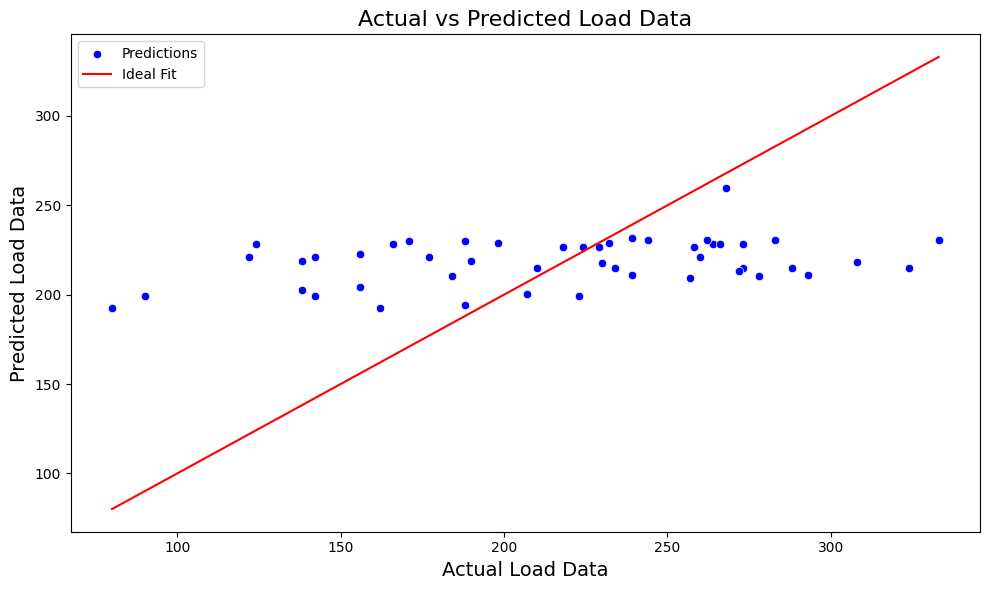

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Step 3: Predict on the test set
y_pred = rf.predict(X_test)

# Step 4: Calculate accuracy (R-squared and RMSE)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Output the results
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predictions')
sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal Fit')

# Add labels and title
plt.title('Actual vs Predicted Load Data', fontsize=16)
plt.xlabel('Actual Load Data', fontsize=14)
plt.ylabel('Predicted Load Data', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()


### XG BOOST

In [183]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

print(f'XGBoost R-squared: {r2_xgb}')
print(f'XGBoost RMSE: {rmse_xgb}')
print("Mean absolute percentage error: ",  mean_absolute_percentage_error(y_test, y_pred))


XGBoost R-squared: 0.049916863441467285
XGBoost RMSE: 58.92943717444563
Mean absolute percentage error:  0.26764236245675094


/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### GradientBoostingRegressor

In [184]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
model = GradientBoostingRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Setup the GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train model with best parameters
best_model = GradientBoostingRegressor(**best_params)
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_test)
print("GradientBoostingRegressor R-squared:", r2_score(y_test, y_pred))
print("GradientBoostingRegressor RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Mean absolute percentage error: ",  mean_absolute_percentage_error(y_test, y_pred))


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
GradientBoostingRegressor R-squared: 0.0004922239896025804
GradientBoostingRegressor RMSE: 60.442802441664526
Mean absolute percentage error:  0.2904185770586393


/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### lightgbm

In [185]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
model = lgb.LGBMRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 63],
    'max_depth': [-1, 10, 20]
}

# Setup the GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train model with best parameters
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_test)
print("LightGBM R-squared:", r2_score(y_test, y_pred))
print("LightGBM RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Mean absolute percentage error: ",  mean_absolute_percentage_error(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 7086, number of used features: 1
[LightGBM] [Info] Start training from score 209.443268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 7085, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 8857, number of used features: 1
[LightGBM] [Info] Start training from score 214.286214
Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 8857, number of used features: 1
[LightGBM] [Info] Start training from score 214.286214
LightGBM R-squared: 0.033569773178564466
LightGBM RMSE: 59.43424580722932
Mean absolute percentage error:  0.28408620441764215


/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [137]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform

# Define the model
model = lgb.LGBMRegressor()

# Define hyperparameters to explore
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 100),
    'max_depth': randint(-1, 20),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters from Randomized Search:", best_params)

# Train model with best parameters
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_test)
print("LightGBM Randomized Search R-squared:", r2_score(y_test, y_pred))
print("LightGBM Randomized Search RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Mean absolute percentage error: ",  mean_absolute_percentage_error(y_test, y_pred))



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 7067, number of used features: 1
[LightGBM] [Info] Start training from score 209.456771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 7067, number of used features: 1
[LightGBM] [Info] Start training from score 210.941559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 7

/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/hammad/src/hacakathon_uis/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt



# Function to evaluate model on a specific day
def evaluate_day(day_data):

    arima_pred = arima_model(y_train, len(y_day))
    
    meta_X = np.column_stack((xgb_pred, rf_pred, arima_pred))
    day_pred = meta_learner.predict(meta_X)
    
    mae = mean_absolute_error(y_day, day_pred)
    mape = mean_absolute_percentage_error(y_day, day_pred)
    return mae, mape, y_day.mean(), day_pred.mean()

# Evaluate over 10 different test sets
num_test_sets = 10
days_per_set = 2
all_days = data['DateAndHour'].dt.date.unique()

results = []

for i in range(num_test_sets):
    random_days = random.sample(list(all_days), days_per_set)
    set_results = []
    
    for day in random_days:
        day_data = data[data['DateAndHour'].dt.date == day]
        mae, mape, actual_mean, pred_mean = evaluate_day(day_data)
        set_results.append({
            'Date': day,
            'MAE': mae,
            'MAPE': mape,
            'Actual_Mean': actual_mean,
            'Predicted_Mean': pred_mean
        })
    
    results.append(set_results)

# Print results
for i, test_set in enumerate(results):
    print(f"\nTest Set {i+1}:")
    for day_result in test_set:
        print(f"Date: {day_result['Date']}, MAE: {day_result['MAE']:.2f}, "
              f"MAPE: {day_result['MAPE']:.2f}%, "
              f"Actual Mean: {day_result['Actual_Mean']:.2f}, "
              f"Predicted Mean: {day_result['Predicted_Mean']:.2f}")

# Calculate overall statistics
all_maes = [day_result['MAE'] for test_set in results for day_result in test_set]
all_mapes = [day_result['MAPE'] for test_set in results for day_result in test_set]
print(f"\nOverall Statistics:")
print(f"Average MAE: {np.mean(all_maes):.2f}")
print(f"Average MAPE: {np.mean(all_mapes):.2f}%")
print(f"Median MAE: {np.median(all_maes):.2f}")
print(f"Median MAPE: {np.median(all_mapes):.2f}%")
print(f"Min MAE: {np.min(all_maes):.2f}")
print(f"Min MAPE: {np.min(all_mapes):.2f}%")
print(f"Max MAE: {np.max(all_maes):.2f}")
print(f"Max MAPE: {np.max(all_mapes):.2f}%")

# Create a box plot of MAPEs
plt.figure(figsize=(10, 6))
plt.boxplot(all_mapes)
plt.title('Distribution of Mean Absolute Percentage Errors (Ensemble Model)')
plt.ylabel('MAPE (%)')
plt.savefig('ensemble_mape_distribution.svg', format='svg')
plt.close()
